In [2]:
import time
#Ignore the next statement -- it is just to estimate how long the exercise takes
start = time.perf_counter()

In [3]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [4]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, StratifiedShuffleSplit, validation_curve
from sklearn import preprocessing
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import learning_curve

In [5]:
np.random.seed(903967645)

In [6]:
phishing_dataset = pd.read_csv('../data/phishing_dataset.csv')
print(phishing_dataset.info())
phishing_dataset.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11055 entries, 0 to 11054
Data columns (total 32 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   index                        11055 non-null  int64
 1   having_IPhaving_IP_Address   11055 non-null  int64
 2   URLURL_Length                11055 non-null  int64
 3   Shortining_Service           11055 non-null  int64
 4   having_At_Symbol             11055 non-null  int64
 5   double_slash_redirecting     11055 non-null  int64
 6   Prefix_Suffix                11055 non-null  int64
 7   having_Sub_Domain            11055 non-null  int64
 8   SSLfinal_State               11055 non-null  int64
 9   Domain_registeration_length  11055 non-null  int64
 10  Favicon                      11055 non-null  int64
 11  port                         11055 non-null  int64
 12  HTTPS_token                  11055 non-null  int64
 13  Request_URL                  11055 non-null  i

,index,having_IPhaving_IP_Address,URLURL_Length,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,SSLfinal_State,Domain_registeration_length,...,popUpWidnow,Iframe,age_of_domain,DNSRecord,web_traffic,Page_Rank,Google_Index,Links_pointing_to_page,Statistical_report,Result
0,1,-1,1,1,1,-1,-1,-1,-1,-1,...,1,1,-1,-1,-1,-1,1,1,-1,-1
1,2,1,1,1,1,1,-1,0,1,-1,...,1,1,-1,-1,0,-1,1,1,1,-1
2,3,1,0,1,1,1,-1,-1,-1,-1,...,1,1,1,-1,1,-1,1,0,-1,-1
3,4,1,0,1,1,1,-1,-1,-1,1,...,1,1,-1,-1,1,-1,1,-1,1,-1
4,5,1,0,-1,1,1,-1,1,1,-1,...,-1,1,-1,-1,0,-1,1,1,1,1


In [7]:
# Check shape of dataset and for null data
print(phishing_dataset.shape)
phishing_dataset.isna().any().any()

(11055, 32)


False

In [8]:
# Separate features and target
X = phishing_dataset.drop(columns=['Result'])
y = phishing_dataset['Result']

# Normalize the feature data
min_max_scaler = preprocessing.MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(X)

# Convert back to DataFrame
X = pd.DataFrame(X_scaled, columns=X.columns)

In [9]:
%%time
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(X, y):
    strat_train_set = X.iloc[train_index]
    strat_test_set = X.iloc[test_index]
    strat_train_labels = y.iloc[train_index]
    strat_test_labels = y.iloc[test_index]

train_X = strat_train_set
test_X = strat_test_set
train_y = strat_train_labels
test_y = strat_test_labels

CPU times: user 2.91 ms, sys: 1.08 ms, total: 3.99 ms
Wall time: 3.26 ms


In [10]:
%%time
# Instantiate KNN Classifier Model
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=None)
# Train KNN on training data
knn.fit(train_X, train_y)
print(knn.get_params())

{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
CPU times: user 1.64 ms, sys: 999 µs, total: 2.64 ms
Wall time: 1.65 ms


In [11]:
%%time
# Evaluate on training data
train_predictions = knn.predict(train_X)
train_accuracy = accuracy_score(train_y, train_predictions)
train_roc_auc = roc_auc_score(train_y, train_predictions)
train_precision = precision_score(train_y, train_predictions)
train_recall = recall_score(train_y, train_predictions)
train_f1 = f1_score(train_y, train_predictions)

print("Training Accuracy:", train_accuracy)
print("Training ROC AUC Score:", train_roc_auc)
print("Training Precision:", train_precision)
print("Training Recall:", train_recall)
print("Training F1 Score:", train_f1)
train_report = classification_report(train_y, train_predictions)
print(train_report)

# Write to a text file
with open('../results/phishing-knn/training_metrics_report.txt', 'w') as file:
    file.write("Training Accuracy: " + str(train_accuracy) + "\n")
    file.write("Training ROC AUC Score: " + str(train_roc_auc) + "\n")
    file.write("Training Precision: " + str(train_precision) + "\n")
    file.write("Training Recall: " + str(train_recall) + "\n")
    file.write("Training F1 Score: " + str(train_f1) + "\n")
    file.write("\nClassification Report:\n")
    file.write(train_report + "\n")

Training Accuracy: 0.965513342379014
Training ROC AUC Score: 0.9646807980158412
Training Precision: 0.9662966700302724
Training Recall: 0.9719853836784409
Training F1 Score: 0.9691326788786561
              precision    recall  f1-score   support

          -1       0.96      0.96      0.96      3918
           1       0.97      0.97      0.97      4926

    accuracy                           0.97      8844
   macro avg       0.97      0.96      0.97      8844
weighted avg       0.97      0.97      0.97      8844

CPU times: user 1.46 s, sys: 2.72 s, total: 4.17 s
Wall time: 456 ms


In [12]:
%%time
# Evaluate on testing data
test_predictions = knn.predict(test_X)
test_accuracy = accuracy_score(test_y, test_predictions)
test_roc_auc = roc_auc_score(test_y, test_predictions)
test_precision = precision_score(test_y, test_predictions)
test_recall = recall_score(test_y, test_predictions)
test_f1 = f1_score(test_y, test_predictions)

print("Testing Accuracy:", test_accuracy)
print("Testing ROC AUC Score:", test_roc_auc)
print("Testing Precision:", test_precision)
print("Testing Recall:", test_recall)
print("Testing F1 Score:", test_f1)
test_report = classification_report(test_y, test_predictions)
print(test_report)

# Write to a text file
with open('../results/phishing-knn/testing_metrics_report.txt', 'w') as file:
    file.write("Testing Accuracy: " + str(test_accuracy) + "\n")
    file.write("Testing ROC AUC Score: " + str(test_roc_auc) + "\n")
    file.write("Testing Precision: " + str(test_precision) + "\n")
    file.write("Testing Recall: " + str(test_recall) + "\n")
    file.write("Testing F1 Score: " + str(test_f1) + "\n")
    file.write("\nClassification Report:\n")
    file.write(test_report + "\n")

Testing Accuracy: 0.9516056083220262
Testing ROC AUC Score: 0.9504016147482551
Testing Precision: 0.9524959742351047
Testing Recall: 0.9610073111291633
Testing F1 Score: 0.9567327133036797
              precision    recall  f1-score   support

          -1       0.95      0.94      0.95       980
           1       0.95      0.96      0.96      1231

    accuracy                           0.95      2211
   macro avg       0.95      0.95      0.95      2211
weighted avg       0.95      0.95      0.95      2211

CPU times: user 303 ms, sys: 195 ms, total: 498 ms
Wall time: 57.9 ms


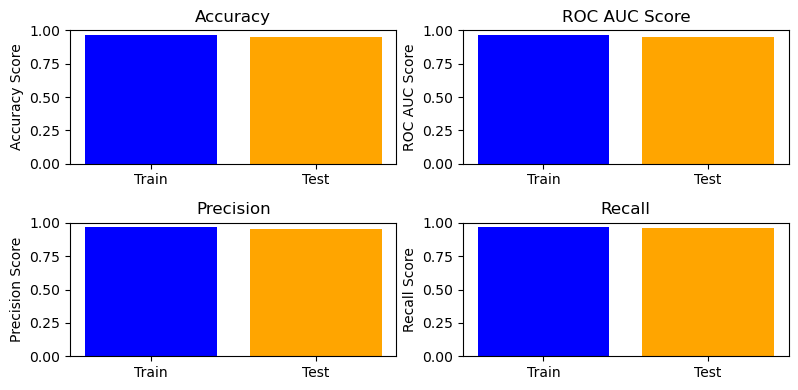

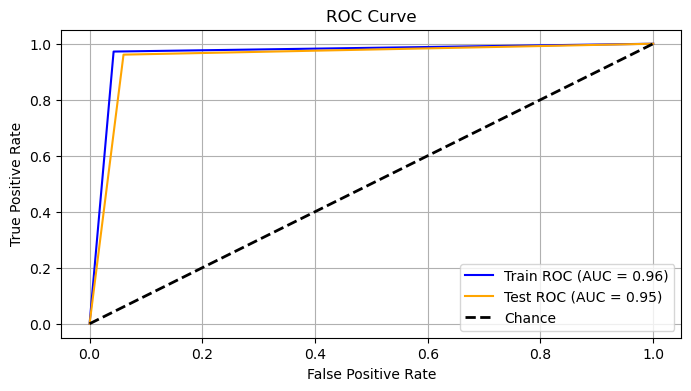

CPU times: user 1.23 s, sys: 627 ms, total: 1.85 s
Wall time: 281 ms


In [13]:
%%time
fig, ax = plt.subplots(2, 2, figsize=(8, 4))

# Accuracy
ax[0, 0].bar(['Train', 'Test'], [train_accuracy, test_accuracy], color=['blue', 'orange'])
ax[0, 0].set_title('Accuracy')
ax[0, 0].set_ylim([0, 1])
ax[0, 0].set_ylabel('Accuracy Score')

# ROC AUC Score
ax[0, 1].bar(['Train', 'Test'], [train_roc_auc, test_roc_auc], color=['blue', 'orange'])
ax[0, 1].set_title('ROC AUC Score')
ax[0, 1].set_ylim([0, 1])
ax[0, 1].set_ylabel('ROC AUC Score')

# Precision
ax[1, 0].bar(['Train', 'Test'], [train_precision, test_precision], color=['blue', 'orange'])
ax[1, 0].set_title('Precision')
ax[1, 0].set_ylim([0, 1])
ax[1, 0].set_ylabel('Precision Score')

# Recall
ax[1, 1].bar(['Train', 'Test'], [train_recall, test_recall], color=['blue', 'orange'])
ax[1, 1].set_title('Recall')
ax[1, 1].set_ylim([0, 1])
ax[1, 1].set_ylabel('Recall Score')

plt.tight_layout()
fig.savefig('../images/phishing-knn/metrics-comparison.png')
plt.show()

# Plotting  ROC Curves
train_fpr, train_tpr, _ = roc_curve(train_y, train_predictions)
test_fpr, test_tpr, _ = roc_curve(test_y, test_predictions)

plt.figure(figsize=(8, 4))
plt.plot(train_fpr, train_tpr, label=f'Train ROC (AUC = {auc(train_fpr, train_tpr):.2f})', color='blue')
plt.plot(test_fpr, test_tpr, label=f'Test ROC (AUC = {auc(test_fpr, test_tpr):.2f})', color='orange')
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Chance')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.savefig('../images/phishing-knn/roc-curve-fpr-tpr')
plt.show()

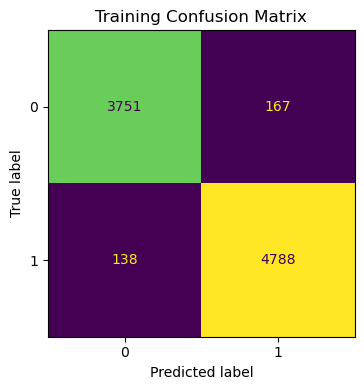

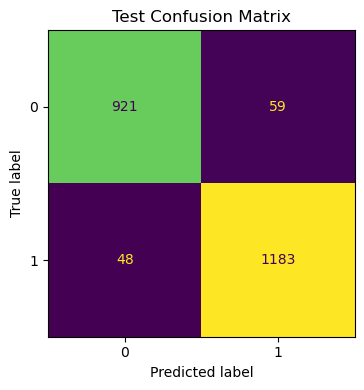

CPU times: user 374 ms, sys: 8.78 ms, total: 383 ms
Wall time: 128 ms


In [14]:
%%time
# Plot and save Training Confusion Matrix
fig, ax = plt.subplots(figsize=(8, 4))
train_cm = confusion_matrix(train_y, train_predictions)
ConfusionMatrixDisplay(train_cm).plot(ax=ax, colorbar=False)
ax.set_title("Training Confusion Matrix")
plt.tight_layout()
plt.savefig('../images/phishing-knn/training-cm.png')
plt.show()

# Plot and save Test Confusion Matrix
fig, ax = plt.subplots(figsize=(8, 4))
test_cm = confusion_matrix(test_y, test_predictions)
ConfusionMatrixDisplay(test_cm).plot(ax=ax, colorbar=False)
ax.set_title('Test Confusion Matrix')
plt.tight_layout()
plt.savefig('../images/phishing-knn/testing-cm.png')
plt.show()

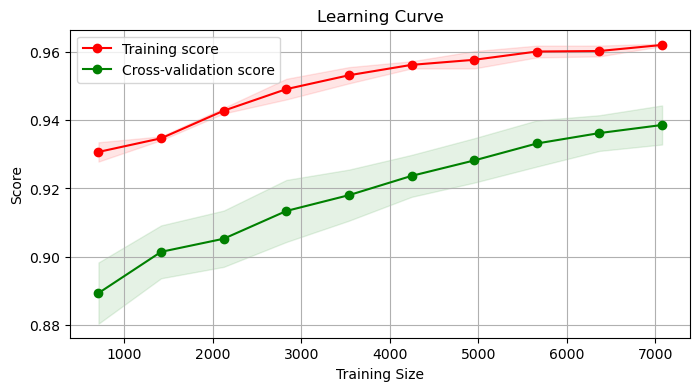

CPU times: user 29.9 s, sys: 16.5 s, total: 46.4 s
Wall time: 5.33 s


In [15]:
%%time
train_sizes, train_scores, test_scores = learning_curve(knn, train_X, train_y, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10))

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(8, 4))
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label="Cross-validation score")

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color='g')

plt.title('Learning Curve')
plt.xlabel('Training Size')
plt.ylabel('Score')
plt.legend(loc='best')
plt.grid()
plt.savefig('../images/phishing-knn/learning-curve-training-size.png')
plt.show()

Shape of train_X: (8844, 31)
Shape of y: (8844,)


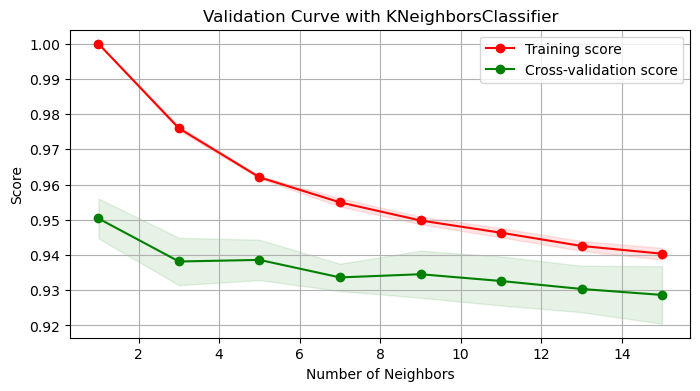

CPU times: user 371 ms, sys: 902 ms, total: 1.27 s
Wall time: 2.99 s


In [16]:
%%time
# Check the shape of train_X and y
print(f'Shape of train_X: {train_X.shape}')
print(f'Shape of y: {train_y.shape}')

# Ensure train_X and y have the same number of samples
assert train_X.shape[0] == train_y.shape[0], "Mismatch in number of samples between train_X and y"

param_range = [1, 3, 5, 7, 9, 11, 13, 15]  # Example range for number of neighbors
train_scores, test_scores = validation_curve(KNeighborsClassifier(), train_X, train_y, param_name="n_neighbors", param_range=param_range, cv=5, scoring='accuracy', n_jobs=-1)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(8, 4))
plt.plot(param_range, train_scores_mean, 'o-', color='r', label="Training score")
plt.plot(param_range, test_scores_mean, 'o-', color='g', label="Cross-validation score")

plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color='r')
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color='g')

plt.title('Validation Curve with KNeighborsClassifier')
plt.xlabel('Number of Neighbors')
plt.ylabel('Score')
plt.legend(loc='best')
plt.grid()
plt.savefig('../images/phishing-knn/validation-curve-number-of-neighbors.png')
plt.show()

In [17]:
%%time
# Perform 10-fold cross-validation
cv_scores = cross_val_score(knn, train_X, train_y, cv=10, scoring='accuracy')

# Print cross-validation scores
print("Cross-validation scores:", cv_scores)
print("mean cross-validation score:", cv_scores.mean())

# Write cross-validation scores to a text file
with open('../results/phishing-knn/cross_validation_scores.txt', 'w') as file:
    file.write("Cross-validation scores: " + np.array2string(cv_scores) + "\n")
    file.write("Mean cross-validation score: " + str(cv_scores.mean()) + "\n")

Cross-validation scores: [0.94011299 0.95819209 0.93446328 0.95028249 0.93891403 0.92986425
 0.94909502 0.94230769 0.93891403 0.94004525]
mean cross-validation score: 0.9422191118950838
CPU times: user 1.39 s, sys: 1.59 s, total: 2.99 s
Wall time: 358 ms


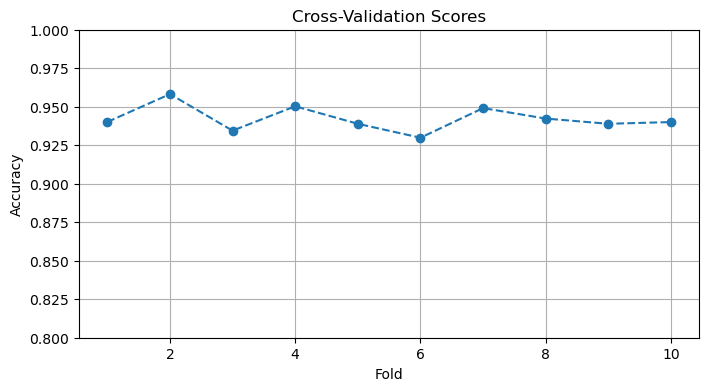

In [18]:
# Plot cross-validation scores
plt.figure(figsize=(8, 4))
plt.plot(range(1, 11), cv_scores, marker='o', linestyle='--')
plt.title('Cross-Validation Scores')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])
plt.grid(True)
plt.savefig('../images/phishing-knn/cross-validation-scores.png')
plt.show()

              precision    recall  f1-score   support

          -1       0.94      0.93      0.93      3918
           1       0.94      0.95      0.95      4926

    accuracy                           0.94      8844
   macro avg       0.94      0.94      0.94      8844
weighted avg       0.94      0.94      0.94      8844



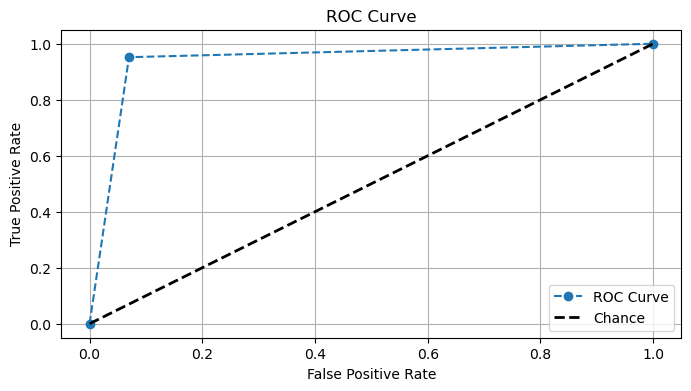

CPU times: user 1.91 s, sys: 1.09 s, total: 3.01 s
Wall time: 370 ms


In [19]:
%%time
y_pred = cross_val_predict(knn, train_X, train_y, cv=10)

report = classification_report(train_y, y_pred)
print(report)

with open('../results/phishing-knn/classification_report.txt', 'w') as file:
    file.write(report)

fpr, tpr, thresholds = roc_curve(train_y, y_pred, pos_label=1)
plt.figure(figsize=(8, 4))
plt.plot(fpr, tpr, marker='o', linestyle='--', label='ROC Curve')
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Chance')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.savefig('../images/phishing-knn/roc-curve-fpr.png')
plt.show()

In [20]:
%%time
# Initialize the KNeighborsClassifier
knn = KNeighborsClassifier()

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

# Fit GridSearchCV on the training data
grid_search.fit(train_X, train_y)

# Print the best parameters and best score found by GridSearchCV
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)

# Write the best parameters and best score to a text file
with open('../results/phishing-knn/grid_search_results.txt', 'w') as file:
    file.write("Best parameters found: " + str(grid_search.best_params_) + "\n")
    file.write("Best cross-validation score: " + str(grid_search.best_score_) + "\n")

Fitting 5 folds for each of 192 candidates, totalling 960 fits
Best parameters found:  {'algorithm': 'auto', 'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}
Best cross-validation score:  0.9604255925964769
CPU times: user 960 ms, sys: 319 ms, total: 1.28 s
Wall time: 19.9 s


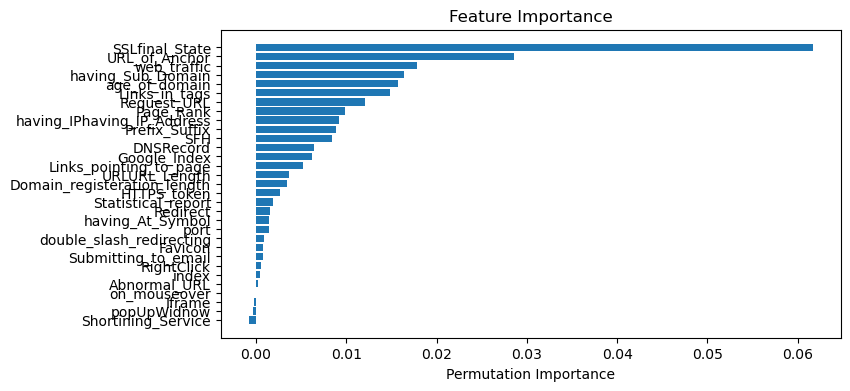

In [21]:
best_knn = grid_search.best_estimator_
best_knn.fit(train_X, train_y)

result = permutation_importance(best_knn, test_X, test_y, n_repeats=10, random_state=42, n_jobs=1)

# Plot feature importance
sorted_idx = result.importances_mean.argsort()
plt.figure(figsize=(8, 4))
plt.barh(train_X.columns[sorted_idx], result.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.title("Feature Importance")
plt.savefig('../images/phishing-knn/feature-importance.png')
plt.show()

              precision    recall  f1-score   support

          -1    0.95747   0.94184   0.94959       980
           1    0.95429   0.96669   0.96045      1231

    accuracy                        0.95568      2211
   macro avg    0.95588   0.95427   0.95502      2211
weighted avg    0.95570   0.95568   0.95564      2211

[[ 923   57]
 [  41 1190]]


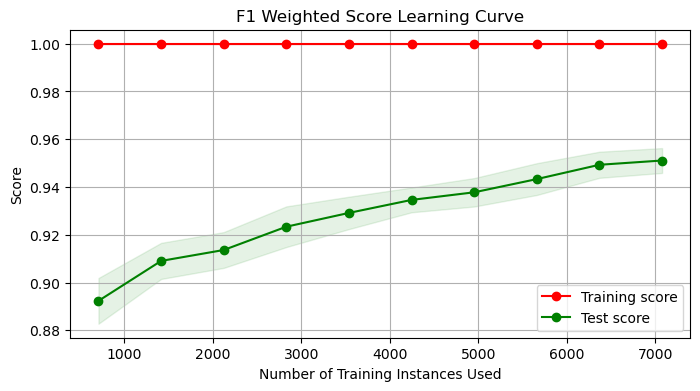

CPU times: user 840 ms, sys: 161 ms, total: 1 s
Wall time: 967 ms


In [22]:
%%time
best_knn = KNeighborsClassifier(n_neighbors=5, weights='distance', algorithm='auto', leaf_size=30, p=2, metric='minkowski')

best_knn.fit(train_X, train_y)
test_predictions = best_knn.predict(test_X)

# Generate classification report
test_report = classification_report(test_y, test_predictions, digits=5)

# Generate confusion matrix
test_cm = confusion_matrix(test_y, test_predictions)

# Print to console
print(test_report)
print(test_cm)

# Generate learning curve data
train_sizes, train_scores, test_scores = learning_curve(
    best_knn, train_X, train_y, cv=5, scoring='f1_weighted',
    train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
)

# Calculate mean and standard deviation
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(8, 4))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Test score")

plt.title('F1 Weighted Score Learning Curve')
plt.xlabel('Number of Training Instances Used')
plt.ylabel('Score')
plt.legend(loc="best")
plt.grid()
plt.savefig('../images/phishing-knn/best-nn-training-vs-test-set')
plt.show()

# Write to a text file
with open('../results/phishing-knn/test_classification_results.txt', 'w') as file:
    file.write("Classification Report:\n")
    file.write(test_report + "\n")
    file.write("Confusion Matrix:\n")
    file.write(np.array2string(test_cm) + "\n")

In [23]:
end = time.perf_counter()
print("Time taken: in min", (end - start)/60)

Time taken: in min 0.8255558617999971
[CV] END algorithm=auto, metric=euclidean, n_neighbors=1, weights=uniform; total time=   0.1s
[CV] END algorithm=auto, metric=euclidean, n_neighbors=3, weights=uniform; total time=   0.1s
[CV] END algorithm=auto, metric=euclidean, n_neighbors=5, weights=uniform; total time=   0.1s
[CV] END algorithm=auto, metric=euclidean, n_neighbors=5, weights=distance; total time=   0.1s
[CV] END algorithm=auto, metric=euclidean, n_neighbors=9, weights=uniform; total time=   0.1s
[CV] END algorithm=auto, metric=euclidean, n_neighbors=9, weights=distance; total time=   0.1s
[CV] END algorithm=auto, metric=euclidean, n_neighbors=15, weights=distance; total time=   0.1s
[CV] END algorithm=auto, metric=euclidean, n_neighbors=15, weights=distance; total time=   0.1s
[CV] END algorithm=auto, metric=euclidean, n_neighbors=15, weights=distance; total time=   0.1s
[CV] END algorithm=auto, metric=euclidean, n_neighbors=15, weights=distance; total time=   0.1s
[CV] END alg